### Decoding the .obj File and Choosing Data Structures

In [37]:
class Mesh:
    def __init__(self):
        self.vertices = []  # List of tuples (x, y, z)
        self.normals = []   # List of tuples (nx, ny, nz)
        self.tex_coords = [] # List of tuples (u, v)
        self.faces = []     # List of lists, each inner list representing a face
                             # and containing tuples of (vertex_index, tex_coord_index, normal_index)

def load_obj(filepath):
    mesh = Mesh()
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if not parts:
                    continue
                keyword = parts[0]
                data = parts[1:]

                if keyword == 'v':
                    mesh.vertices.append(tuple(map(float, data)))
                elif keyword == 'vn':
                    mesh.normals.append(tuple(map(float, data)))
                elif keyword == 'vt':
                    mesh.tex_coords.append(tuple(map(float, data)))
                elif keyword == 'f':
                    face_data = []
                    for vertex_data in data:
                        indices = vertex_data.split('/')
                        vertex_index = int(indices[0]) - 1 if indices[0] else None
                        tex_coord_index = int(indices[1]) - 1 if len(indices) > 1 and indices[1] else None
                        normal_index = int(indices[2]) - 1 if len(indices) > 2 and indices[2] else None
                        face_data.append((vertex_index, tex_coord_index, normal_index))
                    mesh.faces.append(face_data)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    return mesh

### Implementing Vertex Clustering

In [38]:
import numpy as np

def vertex_clustering(mesh, grid_size):
    """Reduces the mesh using vertex clustering.

    Args:
        mesh: The Mesh object.
        grid_size: The size of the grid cells (e.g., a float).

    Returns:
        A new Mesh object representing the simplified mesh.
    """
    simplified_mesh = Mesh()
    clusters = {}  

    
    for i, vertex in enumerate(mesh.vertices):
        cell_index = tuple(np.floor(np.array(vertex) / grid_size).astype(int))
        if cell_index not in clusters:
            clusters[cell_index] = []
        clusters[cell_index].append(i)

    
    representative_vertices = {}  
    new_vertices = []
    for cell_index, vertex_indices in clusters.items():
        if vertex_indices:
            cluster_points = np.array([mesh.vertices[i] for i in vertex_indices])
            centroid = np.mean(cluster_points, axis=0)
            new_vertices.append(tuple(centroid))
            for original_index in vertex_indices:
                representative_vertices[original_index] = len(new_vertices) - 1

    simplified_mesh.vertices = new_vertices

    
    new_faces = []
    for face in mesh.faces:
        new_face_vertices = []
        valid_face = True
        for vertex_index_tuple in face:
            original_vertex_index = vertex_index_tuple[0] 
            if original_vertex_index is not None and original_vertex_index in representative_vertices:
                new_face_vertices.append(representative_vertices[original_vertex_index])
            else:
                valid_face = False 
                break

        
        if valid_face and len(set(new_face_vertices)) >= 3:  
            simplified_mesh.faces.append(tuple([(v_idx, None, None) for v_idx in new_face_vertices])) 

    return simplified_mesh

### Implementing Edge Collapse

In [39]:
import heapq

def edge_collapse(mesh, target_ratio):

    simplified_mesh = Mesh()
    vertices = list(mesh.vertices)
    faces = list(mesh.faces)

    vertex_edges = [set() for _ in vertices]
    edge_faces = {}  

    for face_index, face in enumerate(faces):
        for i in range(len(face)):
            v1_index = face[i][0]
            v2_index = face[(i + 1) % len(face)][0]
            if v1_index is not None and v2_index is not None:
                edge = tuple(sorted((v1_index, v2_index)))
                vertex_edges[v1_index].add(edge)
                vertex_edges[v2_index].add(edge)
                if edge not in edge_faces:
                    edge_faces[edge] = []
                edge_faces[edge].append(face_index)

    
    def calculate_collapse_cost(edge):
        v1_index, v2_index = edge
        return np.linalg.norm(np.array(vertices[v1_index]) - np.array(vertices[v2_index]))

    priority_queue = [(calculate_collapse_cost(edge), edge) for edge in edge_faces]
    heapq.heapify(priority_queue)

    num_vertices_to_remove = len(vertices) - int(len(vertices) * target_ratio)
    collapsed_vertices = [False] * len(vertices)

    for _ in range(num_vertices_to_remove):
        if not priority_queue:
            break

        cost, edge_to_collapse = heapq.heappop(priority_queue)
        v1_index, v2_index = edge_to_collapse

        if collapsed_vertices[v1_index] or collapsed_vertices[v2_index]:
            continue 

        
        new_vertex_position = tuple(np.mean([vertices[v1_index], vertices[v2_index]], axis=0))

        
        updated_faces = []
        for face_index, face in enumerate(faces):
            new_face = list(face)
            for i in range(len(new_face)):
                if new_face[i][0] == v1_index or new_face[i][0] == v2_index:
                    new_face[i] = (len(simplified_mesh.vertices), new_face[i][1], new_face[i][2]) 
            updated_faces.append(tuple(new_face))
        faces = updated_faces

        simplified_mesh.vertices.append(new_vertex_position)
        collapsed_vertices[v1_index] = True
        collapsed_vertices[v2_index] = True

        
        faces = [face for face in faces if len(set(v[0] for v in face if v[0] is not None)) >= 3]

        

    # Finalize the simplified mesh
    simplified_mesh.vertices = [v for i, v in enumerate(vertices) if not collapsed_vertices[i]]
    vertex_mapping = {old_index: new_index for new_index, old_index in enumerate(i for i, collapsed in enumerate(collapsed_vertices) if not collapsed)}
    for face in faces:
        new_face_indices = [vertex_mapping.get(v[0]) for v in face if v[0] is not None and v[0] in vertex_mapping]
        if len(new_face_indices) >= 3:
            simplified_mesh.faces.append(tuple([(idx, None, None) for idx in new_face_indices]))

    return simplified_mesh

### Comparing Results

In [1]:
def compare_meshes(original_mesh, simplified_mesh_vc, simplified_mesh_ec):
    """Compares the number of vertices and faces of the original and simplified meshes."""
    print("Original Mesh:")
    print(f"  Vertices: {len(original_mesh.vertices)}")
    print(f"  Faces: {len(original_mesh.faces)}")

    print("\nVertex Clustering Simplified Mesh:")
    print(f"  Vertices: {len(simplified_mesh_vc.vertices)}")
    print(f"  Faces: {len(simplified_mesh_vc.faces)}")

    print("\nEdge Collapse Simplified Mesh:")
    print(f"  Vertices: {len(simplified_mesh_ec.vertices)}")
    print(f"  Faces: {len(simplified_mesh_ec.faces)}")

### Saving the Result

In [41]:
def save_obj(mesh, filepath):
    """Saves the Mesh object to an OBJ file."""
    with open(filepath, 'w') as f:
        for v in mesh.vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for vn in mesh.normals:
            f.write(f"vn {vn[0]} {vn[1]} {vn[2]}\n")
        for vt in mesh.tex_coords:
            f.write(f"vt {vt[0]} {vt[1]}\n")
        for face in mesh.faces:
            face_str = "f"
            for indices in face:
                v_idx_str = str(indices[0] + 1) if indices[0] is not None else ""
                vt_idx_str = str(indices[1] + 1) if indices[1] is not None else ""
                vn_idx_str = str(indices[2] + 1) if indices[2] is not None else ""

                if vt_idx_str and vn_idx_str:
                    face_str += f" {v_idx_str}/{vt_idx_str}/{vn_idx_str}"
                elif vt_idx_str:
                    face_str += f" {v_idx_str}/{vt_idx_str}"
                elif vn_idx_str:
                    face_str += f" {v_idx_str}//{vn_idx_str}"
                else:
                    face_str += f" {v_idx_str}"
            f.write(face_str + "\n")

### Putting It All Together (Conceptual Main Script)

In [42]:
dvi2_folder = r"C:\Users\user\OneDrive\Desktop\Master Ai S3\Multimédia\DVI2\DVI2"
import os

for filename in os.listdir(dvi2_folder):
    if filename.endswith(".obj"):
        filepath = os.path.join(dvi2_folder, filename)
        print(f"Processing: {filename}")

        original_mesh = load_obj(filepath)
        if original_mesh:
            # Vertex Clustering
            simplified_vc = vertex_clustering(original_mesh, grid_size=0.1) # Adjust grid_size
            save_obj(simplified_vc, f"simplified_vc_{filename}")

            # Edge Collapse
            simplified_ec = edge_collapse(original_mesh, target_ratio=0.5) # Adjust target_ratio
            save_obj(simplified_ec, f"simplified_ec_{filename}")

            compare_meshes(original_mesh, simplified_vc, simplified_ec)
        print("-" * 30)

Processing: obj1.obj
Original Mesh:
  Vertices: 1369
  Faces: 2734

Vertex Clustering Simplified Mesh:
  Vertices: 1257
  Faces: 2510

Edge Collapse Simplified Mesh:
  Vertices: 771
  Faces: 1545

Visual comparison is recommended using a 3D model viewer.
------------------------------
Processing: obj2.obj
Original Mesh:
  Vertices: 10505
  Faces: 20822

Vertex Clustering Simplified Mesh:
  Vertices: 754
  Faces: 1571

Edge Collapse Simplified Mesh:
  Vertices: 6039
  Faces: 14609

Visual comparison is recommended using a 3D model viewer.
------------------------------
Processing: obj3.obj
Original Mesh:
  Vertices: 2165
  Faces: 4438

Vertex Clustering Simplified Mesh:
  Vertices: 1463
  Faces: 2910

Edge Collapse Simplified Mesh:
  Vertices: 1122
  Faces: 3252

Visual comparison is recommended using a 3D model viewer.
------------------------------
Processing: obj4.obj


KeyboardInterrupt: 

In [58]:
import trimesh
import numpy as np
import os
from IPython.display import display

def visualize_meshes_notebook(original_path, simplified_paths):

    try:
        original_mesh = trimesh.load_mesh(original_path)
    except FileNotFoundError:
        print(f"Error: Original file not found at {original_path}")
        return

    meshes_to_show = [original_mesh]
    names = ["Original"]

    for name, path in simplified_paths.items():
        try:
            simplified_mesh = trimesh.load_mesh(path)
            meshes_to_show.append(simplified_mesh)
            names.append(name)
        except FileNotFoundError:
            print(f"Error: Simplified file not found at {path}")

    # Create a scene
    scene = trimesh.Scene()

    # Add meshes to the scene with translations for side-by-side view
    spacing = 2.0 * original_mesh.bounding_box.extents.max()  
    for i, mesh in enumerate(meshes_to_show):
        transform = np.eye(4)
        transform[:3, 3] = [i * spacing, 0, 0]  
        scene.add_geometry(mesh, node_name=names[i], transform=transform)

    
    scene.show(smooth=False, smooth_value=0.1, backend='pyglet') 
    

def compare_mesh_properties_notebook(original_path, simplified_paths):
    try:
        original_mesh = trimesh.load_mesh(original_path)
        original_vertices = len(original_mesh.vertices)
        original_faces = len(original_mesh.faces)
        print(f"Original Mesh ({os.path.basename(original_path)}):")
        print(f"  Vertices: {original_vertices}")
        print(f"  Faces: {original_faces}")
        print("-" * 30)
    except FileNotFoundError:
        print(f"Error: Original file not found at {original_path}")
        return

    for name, path in simplified_paths.items():
        try:
            simplified_mesh = trimesh.load_mesh(path)
            simplified_vertices = len(simplified_mesh.vertices)
            simplified_faces = len(simplified_mesh.faces)

            vertex_reduction = 100.0 * (original_vertices - simplified_vertices) / original_vertices if original_vertices > 0 else 0
            face_reduction = 100.0 * (original_faces - simplified_faces) / original_faces if original_faces > 0 else 0

            print(f"{name} Simplified Mesh ({os.path.basename(path)}):")
            print(f"  Vertices: {simplified_vertices} (Reduction: {vertex_reduction:.2f}%)")
            print(f"  Faces: {simplified_faces} (Reduction: {face_reduction:.2f}%)")
            print("-" * 30)
        except FileNotFoundError:
            print(f"Error: Simplified file not found at {path}")


dvi2_folder = r"C:\Users\user\OneDrive\Desktop\devoir individuel 2\DVI2_simpl" 


for filename in os.listdir(dvi2_folder):
    if filename.endswith(".obj") and not filename.startswith("simplified_"):
        original_filepath = os.path.join(dvi2_folder, filename)
        base_filename = filename[:-4]  

        simplified_files = {
            "Vertex Clustering": os.path.join(dvi2_folder, f"simplified_vc_{filename}"),
            "Edge Collapse": os.path.join(dvi2_folder, f"simplified_ec_{filename}"),
        }

        print(f"Analyzing {filename}:")
        compare_mesh_properties_notebook(original_filepath, simplified_files)
        visualize_meshes_notebook(original_filepath, simplified_files)
        print("=" * 50)

        
        print(f"Processing file: {filename}")
        try:
            original_mesh = trimesh.load_mesh(original_filepath)
            print(f"Loaded original mesh: {original_filepath}")
        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")


Analyzing obj1.obj:
Original Mesh (obj1.obj):
  Vertices: 1393
  Faces: 2734
------------------------------
Vertex Clustering Simplified Mesh (simplified_vc_obj1.obj):
  Vertices: 1257 (Reduction: 9.76%)
  Faces: 2510 (Reduction: 8.19%)
------------------------------
Edge Collapse Simplified Mesh (simplified_ec_obj1.obj):
  Vertices: 762 (Reduction: 45.30%)
  Faces: 1545 (Reduction: 43.49%)
------------------------------
Processing file: obj1.obj
Loaded original mesh: C:\Users\user\OneDrive\Desktop\devoir individuel 2\DVI2_simpl\obj1.obj
Analyzing obj2.obj:
Original Mesh (obj2.obj):
  Vertices: 13877
  Faces: 20823
------------------------------
Vertex Clustering Simplified Mesh (simplified_vc_obj2.obj):
  Vertices: 754 (Reduction: 94.57%)
  Faces: 1571 (Reduction: 92.46%)
------------------------------
Edge Collapse Simplified Mesh (simplified_ec_obj2.obj):
  Vertices: 6019 (Reduction: 56.63%)
  Faces: 14610 (Reduction: 29.84%)
------------------------------
Processing file: obj2.obj


### 3D Visualization for comparaison


Visualizing the first eligible file: obj1.obj with pyvista:
Original mesh loaded successfully for pyvista: Vertices=1393, Faces=2734
Simplified mesh 'Vertex Clustering' loaded successfully for pyvista: Vertices=1257, Faces=2510
Simplified mesh 'Edge Collapse' loaded successfully for pyvista: Vertices=762, Faces=1545
Attempting to display the scene with pyvista...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


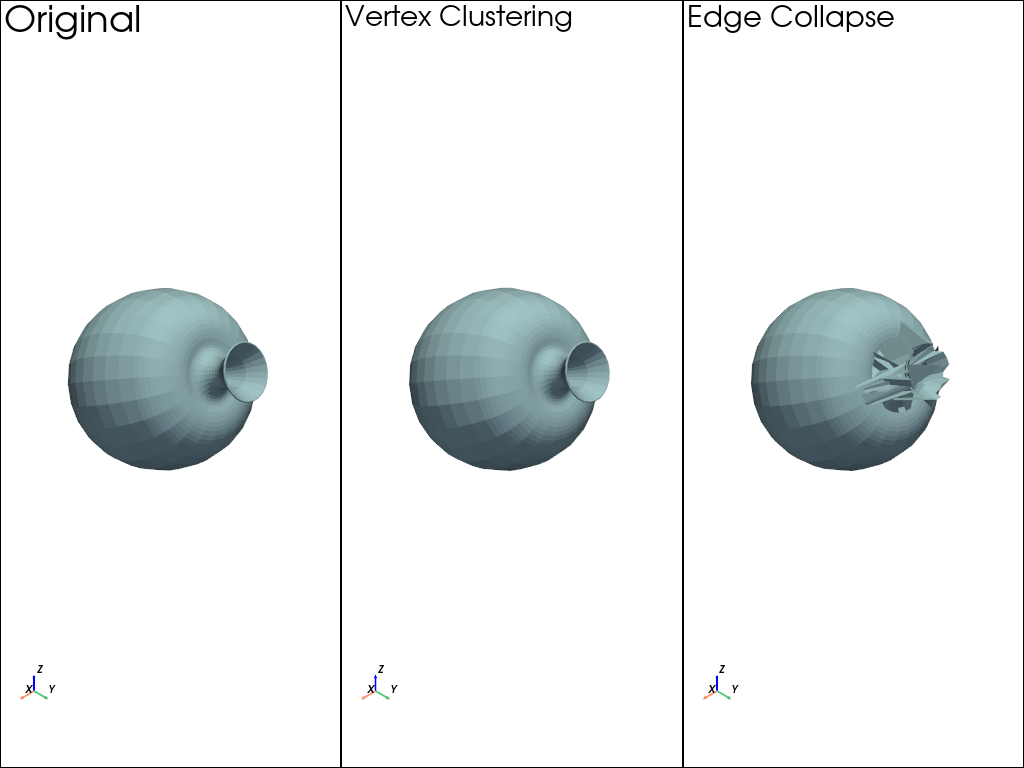


Visualizing the first eligible file: obj2.obj with pyvista:
Original mesh loaded successfully for pyvista: Vertices=13877, Faces=20823
Simplified mesh 'Vertex Clustering' loaded successfully for pyvista: Vertices=754, Faces=1571
Simplified mesh 'Edge Collapse' loaded successfully for pyvista: Vertices=6019, Faces=14610
Attempting to display the scene with pyvista...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


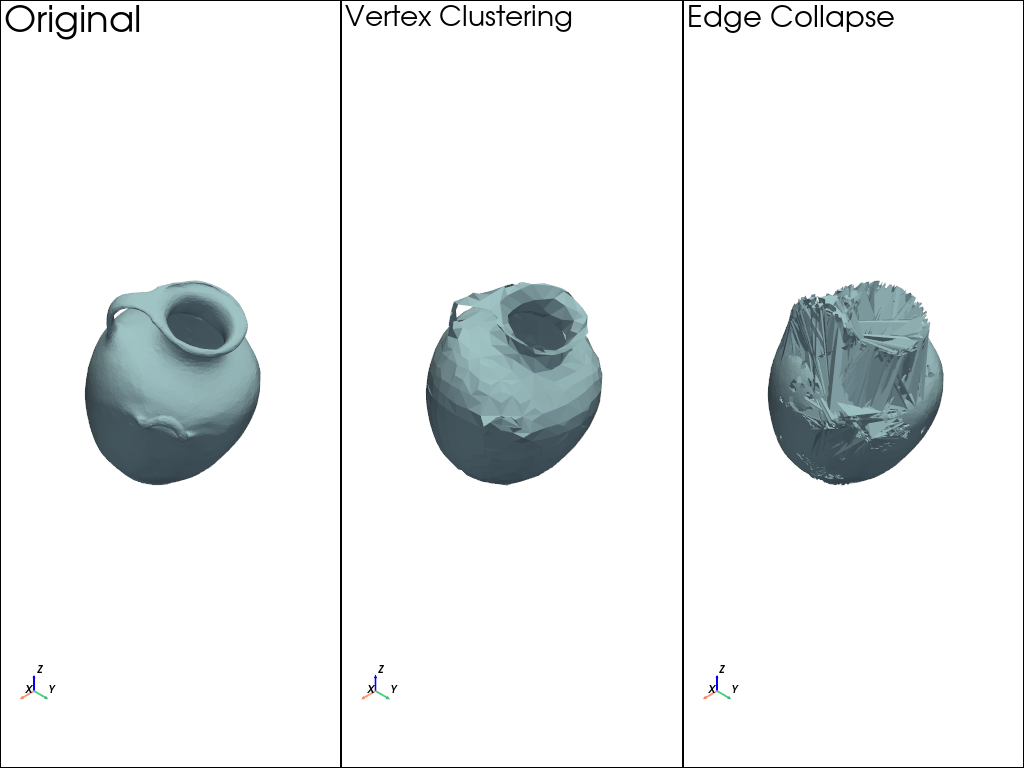


Visualizing the first eligible file: obj3.obj with pyvista:
Original mesh loaded successfully for pyvista: Vertices=2303, Faces=4438
Simplified mesh 'Vertex Clustering' loaded successfully for pyvista: Vertices=1463, Faces=2910
Simplified mesh 'Edge Collapse' loaded successfully for pyvista: Vertices=1122, Faces=3252
Attempting to display the scene with pyvista...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


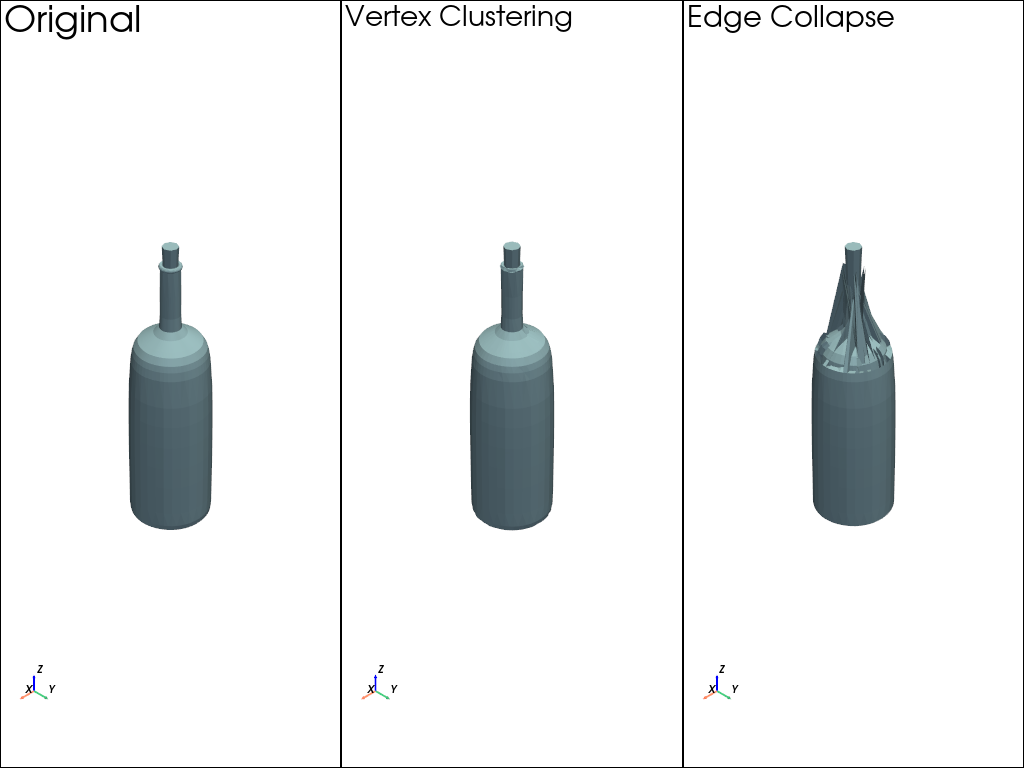

In [3]:
import trimesh
import numpy as np
import os
import pyvista as pv
from IPython.display import display

def visualize_meshes_3d_pyvista(original_path, simplified_paths):
    try:
        original_mesh_trimesh = trimesh.load_mesh(original_path)
        original_mesh_pyvista = pv.wrap(original_mesh_trimesh)
        print(f"Original mesh loaded successfully for pyvista: Vertices={original_mesh_pyvista.n_points}, Faces={original_mesh_pyvista.n_faces}")
    except FileNotFoundError:
        print(f"Error: Original file not found at {original_path}")
        return
    except Exception as e:
        print(f"Error loading original mesh for pyvista: {e}")
        return

    meshes_to_show = {"Original": original_mesh_pyvista}
    for name, path in simplified_paths.items():
        try:
            simplified_mesh_trimesh = trimesh.load_mesh(path)
            simplified_mesh_pyvista = pv.wrap(simplified_mesh_trimesh)
            meshes_to_show[name] = simplified_mesh_pyvista
            print(f"Simplified mesh '{name}' loaded successfully for pyvista: Vertices={simplified_mesh_pyvista.n_points}, Faces={simplified_mesh_pyvista.n_faces}")
        except FileNotFoundError:
            print(f"Error: Simplified file not found at {path}")
        except Exception as e:
            print(f"Error loading simplified mesh '{name}' for pyvista: {e}")

    # Create a pyvista plotter
    num_meshes = len(meshes_to_show)
    plotter = pv.Plotter(shape=(1, num_meshes))

    mesh_names = list(meshes_to_show.keys())
    for i, (name, mesh) in enumerate(meshes_to_show.items()):
        plotter.subplot(0, i)
        plotter.add_mesh(mesh, name=name, color=True)
        plotter.add_text(name, font_size=16)
        plotter.show_axes()
        plotter.view_isometric()

    print("Attempting to display the scene with pyvista...")
    try:
        plotter.show()
    except Exception as e:
        print(f"Error displaying the scene with pyvista: {e}")

if __name__ == "__main__":
    dvi2_folder = "DVI2_simpl"  

    if not os.path.exists(dvi2_folder):
        os.makedirs(dvi2_folder)
        with open(os.path.join(dvi2_folder, "test_model.obj"), "w") as f:
            f.write("v 0 0 0\nv 1 0 0\nv 0 1 0\nf 1 2 3\n")  # Simple triangle
        with open(os.path.join(dvi2_folder, "simplified_vc_test_model.obj"), "w") as f:
            f.write("v 0 0 0\nv 1 0 0\nf 1 2\n") # Simple line
        with open(os.path.join(dvi2_folder, "simplified_ec_test_model.obj"), "w") as f:
            f.write("v 0 0 0\n") # Single point

    for filename in os.listdir(dvi2_folder):
        if filename.endswith(".obj") and not filename.startswith("simplified_"):
            original_filepath = os.path.join(dvi2_folder, filename)
            base_filename = filename[:-4]  # Remove ".obj"

            simplified_files = {
                "Vertex Clustering": os.path.join(dvi2_folder, f"simplified_vc_{filename}"),
                "Edge Collapse": os.path.join(dvi2_folder, f"simplified_ec_{filename}"),
            }

            print(f"\nVisualizing the first eligible file: {filename} with pyvista:")
            visualize_meshes_3d_pyvista(original_filepath, simplified_files)